In [30]:
import re
import sys
import pickle
import numpy as np

import scipy.io as sio
from RegExpReplacement import RegexpReplacer

from sklearn.decomposition import TruncatedSVD

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext, SQLContext


# importing required libraries
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
import pyspark.sql.types as tp


from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StopWordsRemover, Word2Vec, RegexTokenizer
from pyspark.ml.feature import NGram, CountVectorizer, VectorAssembler

from pyspark.ml.regression import GBTRegressor

In [4]:
spark = SparkSession.builder \
.master("local") \
.appName("FirstImpression") \
.getOrCreate()

sc = SparkContext.getOrCreate()

In [5]:
pwd

'/mnt/project-cluster-group7-pvc'

In [6]:
path = "/mnt/project-cluster-group7-pvc/Dataset/"

In [7]:
#https://runawayhorse001.github.io/LearningApacheSpark/textmining.html#text-preprocessin
def List_Punctuations(text):
    text = re.sub('[A-Za-z]|[0-9]|[\n\t]|[£€$%& ]','',text)
    SymbList = list(dict.fromkeys(text).keys())
    #print(SymbList)
    return SymbList

#https://stackoverflow.com/questions/6718633/python-regular-expression-again-match-url
def Extract_URLs(text):
    urls = re.findall('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', text)
    return urls

def Extract_emails(text):
    regex = re.compile(("([a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`"
                    "{|}~-]+)*(@|\sat\s)(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?(\.|"
                    "\sdot\s))+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?)"))

    emails = re.findall(r'[\w\.-]+@[\w\.-]+', text)
    return emails

def Replace_Punctuations(text):
    text = text.replace('.',' ')
    text = text.replace('\'',' ')
    return text

def tokenize(text):
    text = Replace_Punctuations(text)  
    words = text.split()
    return [w for w in words if w is not w.isdigit() and len(w)>1]

In [8]:
def LoadLabels(Annotation):
    Y_I = []
    file = open(Annotation, "rb")
    annotation = pickle.load(file, encoding='latin1')
    for key in annotation['interview'].keys():
        Y_I.append(annotation['interview'][key])
    return Y_I

def LoadDataSet():
    pickle_in = open(path+'transcription_training.pkl',"rb")
    trans_train = pickle.load(pickle_in, encoding='latin1')

    pickle_in = open(path+'transcription_test.pkl',"rb")
    trans_test = pickle.load(pickle_in, encoding='latin1')

    pickle_in = open(path+'transcription_validation.pkl',"rb")
    trans_val = pickle.load(pickle_in, encoding='latin1')

    Y_train = LoadLabels(path+'annotation_training.pkl')
    Y_val = LoadLabels(path+'annotation_validation.pkl')
    Y_test = LoadLabels(path+'annotation_test.pkl')
    
    Text = ' '.join(trans_train.values())+' '.join(trans_val.values())+' '.join(trans_test.values())
    
    Punctuations = List_Punctuations(Text)
    Urls = Extract_URLs(Text)
    Emails = Extract_emails(Text)
    
    train = []
    for key in trans_train.keys():
        train.append(trans_train[key])
        
    val = []
    for key in trans_val.keys():
        val.append(trans_val[key])
    
    test = []
    for key in trans_test.keys():
        test.append(trans_test[key])
        
    return  train, val, test, Y_train, Y_val, Y_test, Punctuations, Urls, Emails


In [9]:
train, val, test, Y_train, Y_val, Y_test, Punctuations, Urls, Emails = LoadDataSet()

# create partitions of the list train, val, test 
train_rdd = sc.parallelize(train,numSlices=50)
val_rdd = sc.parallelize(val,numSlices=10)
test_rdd = sc.parallelize(test,numSlices=10)

Y_train = [float(x) for x in Y_train]
Y_val = [float(x) for x in Y_val]
Y_test = [float(x) for x in Y_test]

In [10]:
def PreprocessTranscript(Transcript):
    Text = re.sub('\[.*?\]', '', Transcript)
    RegReplacer = RegexpReplacer()
    Text = RegReplacer.replace(Text)

    for Url in Urls:
        if Url in Text:
           Text = Text.replace(Url,' link ')    
    for Email in Emails:
        if Email in Text:
           Text = Text.replace(Email,' Email ') 
    for Punctuation in Punctuations:
        Text = Text.replace(Punctuation,' ')
        
    Text = re.sub(r"\s+", " ",Text)
    Text = Text.strip()
            
    return ' '.join(tokenize(Text))

In [11]:
train_rdd = train_rdd.map(lambda x : PreprocessTranscript(x))
val_rdd = val_rdd.map(lambda x : PreprocessTranscript(x))
test_rdd = test_rdd.map(lambda x : PreprocessTranscript(x))               

#df_train = train_rdd.map(lambda x: (x, )).toDF(['Speech'])
#df_val = train_rdd.map(lambda x: (x, )).toDF(['Speech'])
#df_test = test_rdd.map(lambda x: (x, )).toDF(['Speech'])

#df_Y_train = sqlContext.createDataFrame([(float(x), ) for x in Y_train], ['Interview'])
#df_Y_val = sqlContext.createDataFrame([(float(x), ) for x in Y_val], ['Interview'])
#df_Y_test = sqlContext.createDataFrame([(float(x), ) for x in Y_test], ['Interview'])

Train_z = list(zip(range(len(Y_train)+1),train_rdd.collect(), Y_train))
Val_z = list(zip(range(len(Y_val)+1),val_rdd.collect(), Y_val))
Test_z = list(zip(range(len(Y_test)+1),test_rdd.collect(), Y_test))

print(Train_z[0])
print(Val_z[0])
print(Test_z[0])

(0, 'He is cutting it and then turn around and see the end result but glad he did not do that because probably would have lost my mind As it was getting cut was just excited saw the snippets of hair falling to the floor and was like Yes', 0.5046728971962616)
(0, 'and then will do the voice over then will do all the shots so that is me talking it to the camera as well as the shots of the smartphone and all the different things that talking about Then the editing the editing the post production is what takes the longest time It takes huge', 0.616822429906542)
(0, 'link Going nuts from another room run in there to check there is no but it was like the are not there Now maybe just not sleeping enough that moved the scissors somewhere but swear the', 0.6261682242990654)


In [12]:
#from pyspark.sql import functions as F
#from pyspark.sql.window import Window as W

#train_rdd = sc.parallelize(list(zip(train_rdd.collect(), Y_train)),numSlices=20)
#df_train = train_rdd.toDF(['Speech', 'Interview'])
#df_train = df_train.withColumn("Id", F.monotonically_increasing_id())
#windowSpec = W.orderBy("Id")
#df_train = df_train.withColumn("Id", F.row_number().over(windowSpec))

#val_rdd = sc.parallelize(list(zip(val_rdd.collect(), Y_train)),numSlices=10)
#df_val = val_rdd.toDF(['Speech', 'Interview'])

#test_rdd = sc.parallelize(list(zip(test_rdd.collect(), Y_test)),numSlices=10)
#df_test = test_rdd.toDF(['Speech', 'Interview'])

train_rdd = sc.parallelize(Train_z,numSlices=20)
df_train = train_rdd.toDF(['Id', 'Speech', 'Interview'])
df_train.show(5)

val_rdd = sc.parallelize(Val_z,numSlices=10)
df_val = val_rdd.toDF(['Id', 'Speech', 'Interview'])
df_val.show(5)

test_rdd = sc.parallelize(Test_z,numSlices=10)
df_test = test_rdd.toDF(['Id', 'Speech', 'Interview'])
df_test.show(5)

+---+--------------------+-------------------+
| Id|              Speech|          Interview|
+---+--------------------+-------------------+
|  0|He is cutting it ...| 0.5046728971962616|
|  1|Responsibility to...| 0.4579439252336448|
|  2|actually got quit...|0.37383177570093457|
|  3|ate lot would lik...| 0.4579439252336448|
|  4|Now will ask you ...| 0.5700934579439252|
+---+--------------------+-------------------+
only showing top 5 rows

+---+--------------------+-------------------+
| Id|              Speech|          Interview|
+---+--------------------+-------------------+
|  0|and then will do ...|  0.616822429906542|
|  1|Personality is A1...|0.43925233644859807|
|  2|Ewe But yeah some...|0.37383177570093457|
|  3|am makeup artist ...| 0.5233644859813084|
|  4|Sucks When he agr...| 0.3831775700934579|
+---+--------------------+-------------------+
only showing top 5 rows

+---+--------------------+------------------+
| Id|              Speech|         Interview|
+---+-------

In [13]:
df_train.printSchema()

root
 |-- Id: long (nullable = true)
 |-- Speech: string (nullable = true)
 |-- Interview: double (nullable = true)



In [14]:
'https://www.analyticsvidhya.com/blog/2019/12/streaming-data-pyspark-machine-learning-model/'
'https://stackoverflow.com/questions/38839924/how-to-combine-n-grams-into-one-vocabulary-in-spark'

# define stage 1: Tokenize the tweet text    
stage_1 = RegexTokenizer(inputCol= 'Speech' , outputCol= 'tokens', pattern= '\\W')

# define stage 2: Remove the stop words
stage_2 = StopWordsRemover(inputCol= 'tokens', outputCol= 'words')

# define stage 3: Extract unigrams and Bigrams
stage_3 = NGram(n=2, inputCol="words", outputCol="2_grams")

# define stage 4: CountVectorizer
stage_4 = CountVectorizer(inputCol="2_grams",outputCol="features")

# define stage 5: create a word vector of the size 100
stage_5 = Word2Vec(inputCol= '2_grams', outputCol= 'features', vectorSize= 400)

# define stage 6: Linear Regression Model
model = GBTRegressor(featuresCol= 'features', labelCol= 'Interview', maxIter=30, maxDepth = 11)

'https://www.analyticsvidhya.com/blog/2019/12/streaming-data-pyspark-machine-learning-model/'

'https://stackoverflow.com/questions/38839924/how-to-combine-n-grams-into-one-vocabulary-in-spark'

In [15]:
paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [11, 15])\
.addGrid(model.maxIter, [35, 50]).build()
#.addGrid(model.maxBins, MaxBins)\
 

evaluator = RegressionEvaluator(metricName="mae", labelCol=model.getLabelCol(), predictionCol= model.getPredictionCol())
cv = CrossValidator(estimator=model, evaluator=evaluator, estimatorParamMaps=paramGrid)

In [16]:
# setup the pipeline
pipeline = Pipeline(stages= [stage_1, stage_2, stage_3, stage_5, model])
#pipeline = Pipeline(stages= [stage_1, stage_2, stage_3, stage_5, cv])
model = pipeline.fit(df_train)

In [39]:
predictions_val = model.transform(df_val)
predictions = model.transform(df_test)
model.transform(df_test).select('Speech','prediction').show(5)

+--------------------+-------------------+
|              Speech|         prediction|
+--------------------+-------------------+
|link Going nuts f...|   0.52412561613017|
|have got little b...| 0.6428955740399355|
|video is quality ...| 0.5047642943710611|
|You really want t...|0.49066341260928487|
|That is perfectly...| 0.6054304353519901|
+--------------------+-------------------+
only showing top 5 rows



In [18]:
predictions.printSchema()
model.transform(df_test).select('features').show(5)

root
 |-- Id: long (nullable = true)
 |-- Speech: string (nullable = true)
 |-- Interview: double (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- 2_grams: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)

+--------------------+
|            features|
+--------------------+
|[3.91471715244863...|
|[9.68788145756762...|
|[5.32840152599794...|
|[-2.3496989645839...|
|[1.75270588240689...|
+--------------------+
only showing top 5 rows



In [19]:
evaluator = RegressionEvaluator(
labelCol="Interview", predictionCol="prediction", metricName="mae")
mae= evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)
print(1-mae)

MAE on test data = 0.141678
0.8583217594494856


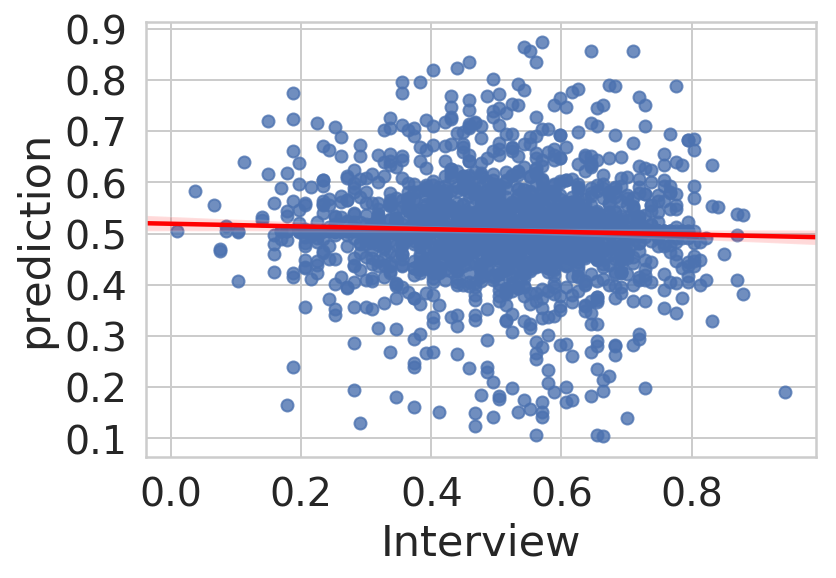

In [32]:
sf03 = predictions.toPandas()
import seaborn
from scipy.stats import *
seaborn.set(style="whitegrid", font_scale = 1.8)
fig, ax = plt.subplots()
seaborn.set(color_codes=True)
seaborn.set(rc={'figure.figsize':(20, 10)})
seaborn.regplot(x="Interview", y="prediction", fit_reg=False, ax=ax, data = sf03, scatter_kws={"color": "b"})
seaborn.regplot(x="Interview", y="prediction", scatter=False, ax=ax, data = sf03 , line_kws={"color": "red"})

#plt.savefig('destination_path.eps', format='eps')
fig.savefig('Interview_Regession.eps')

'https://seaborn.pydata.org/tutorial/distributions.html'

'http://people.duke.edu/~ccc14/cfar-data-2016/Customizing_Plots_Solutions.html'

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.]),
 <a list of 10 Text yticklabel objects>)

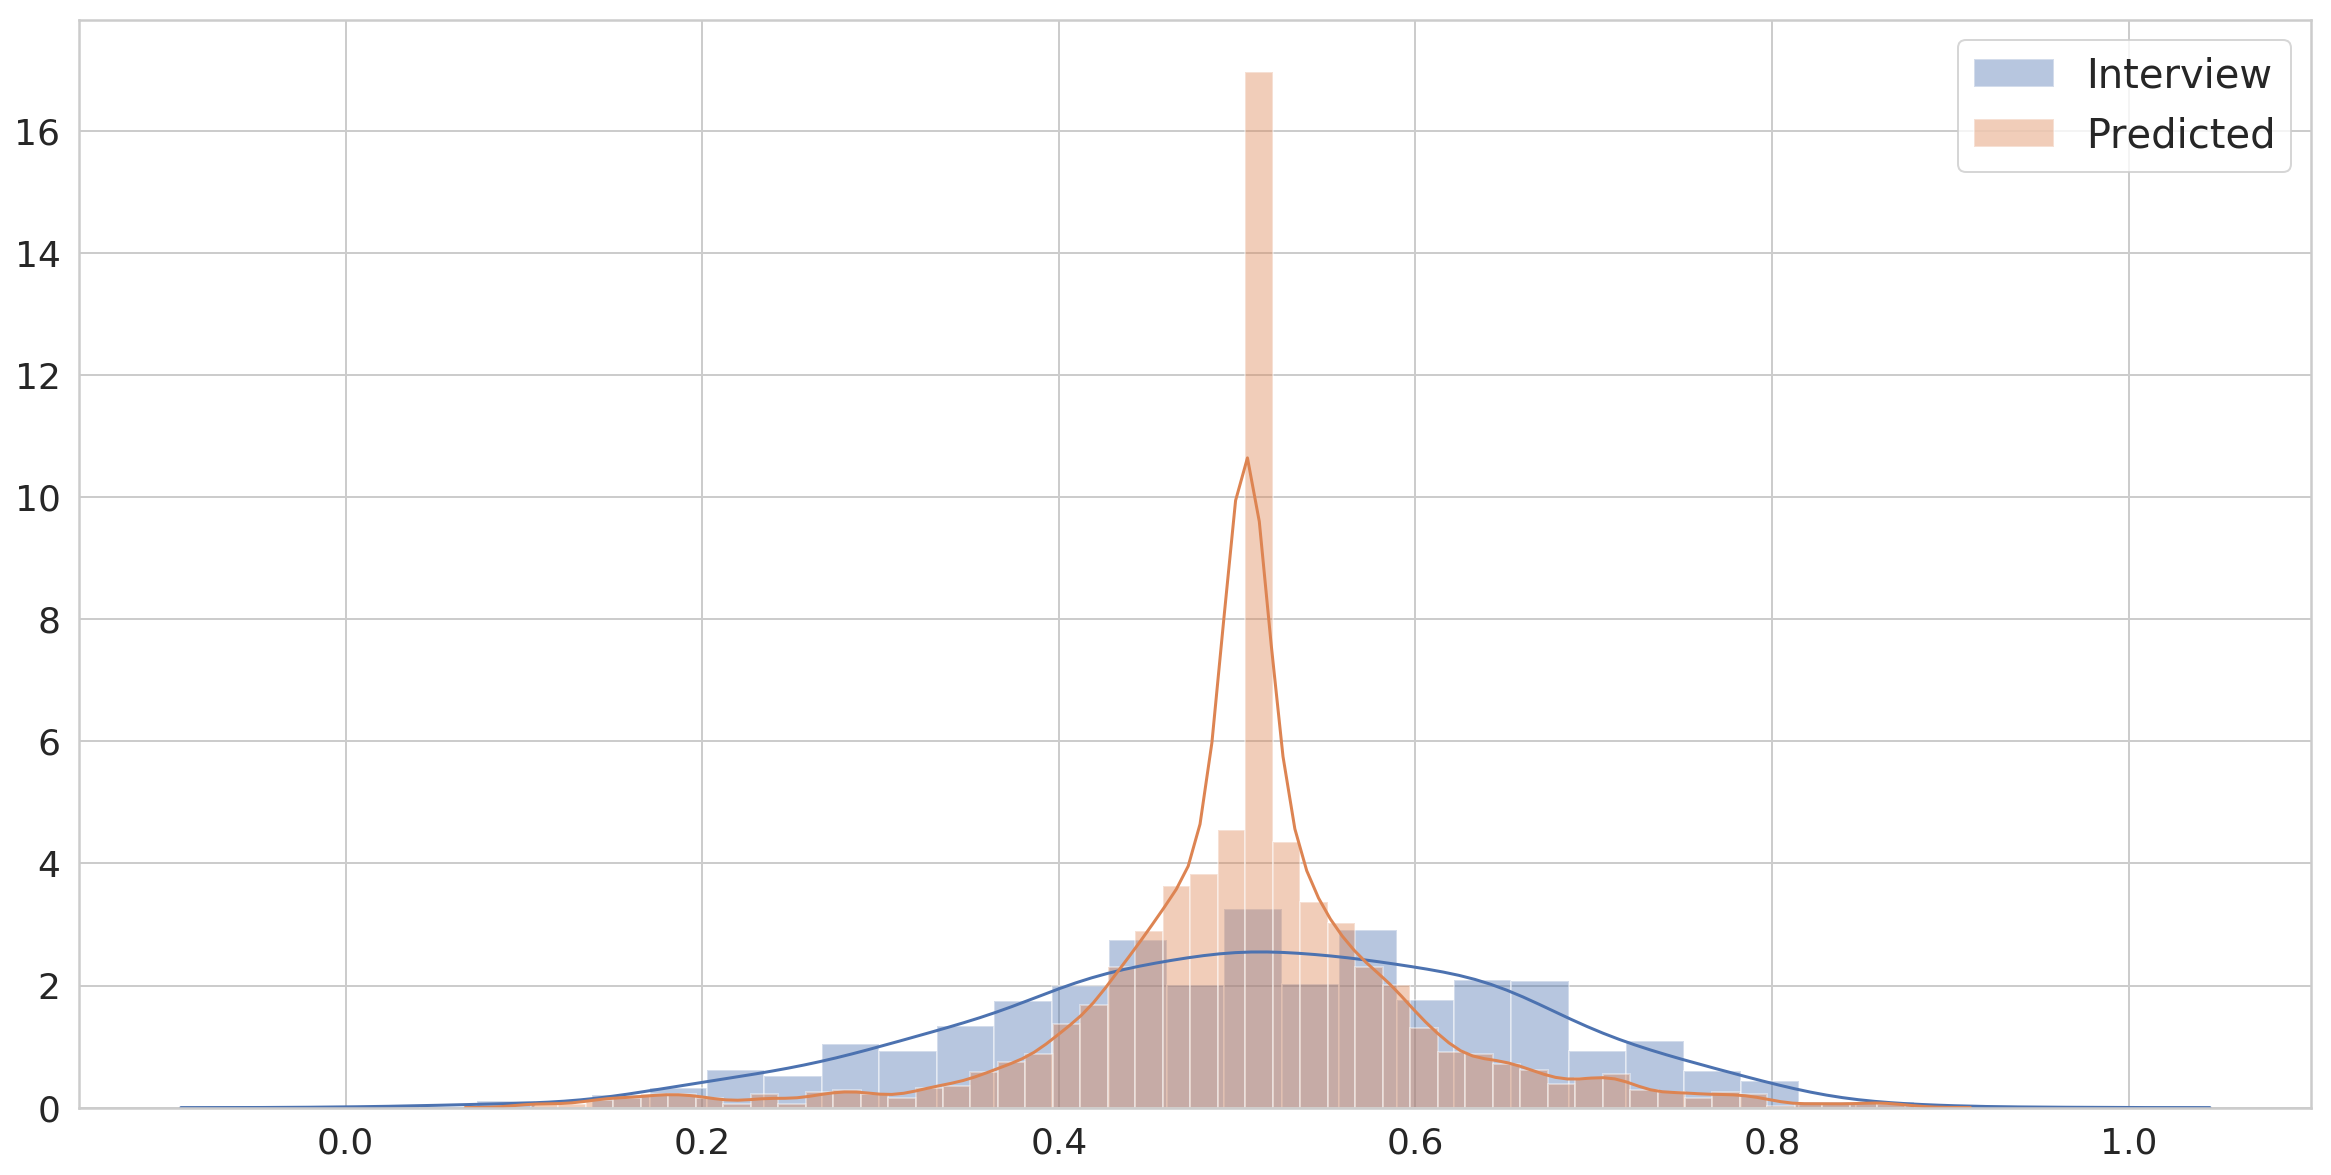

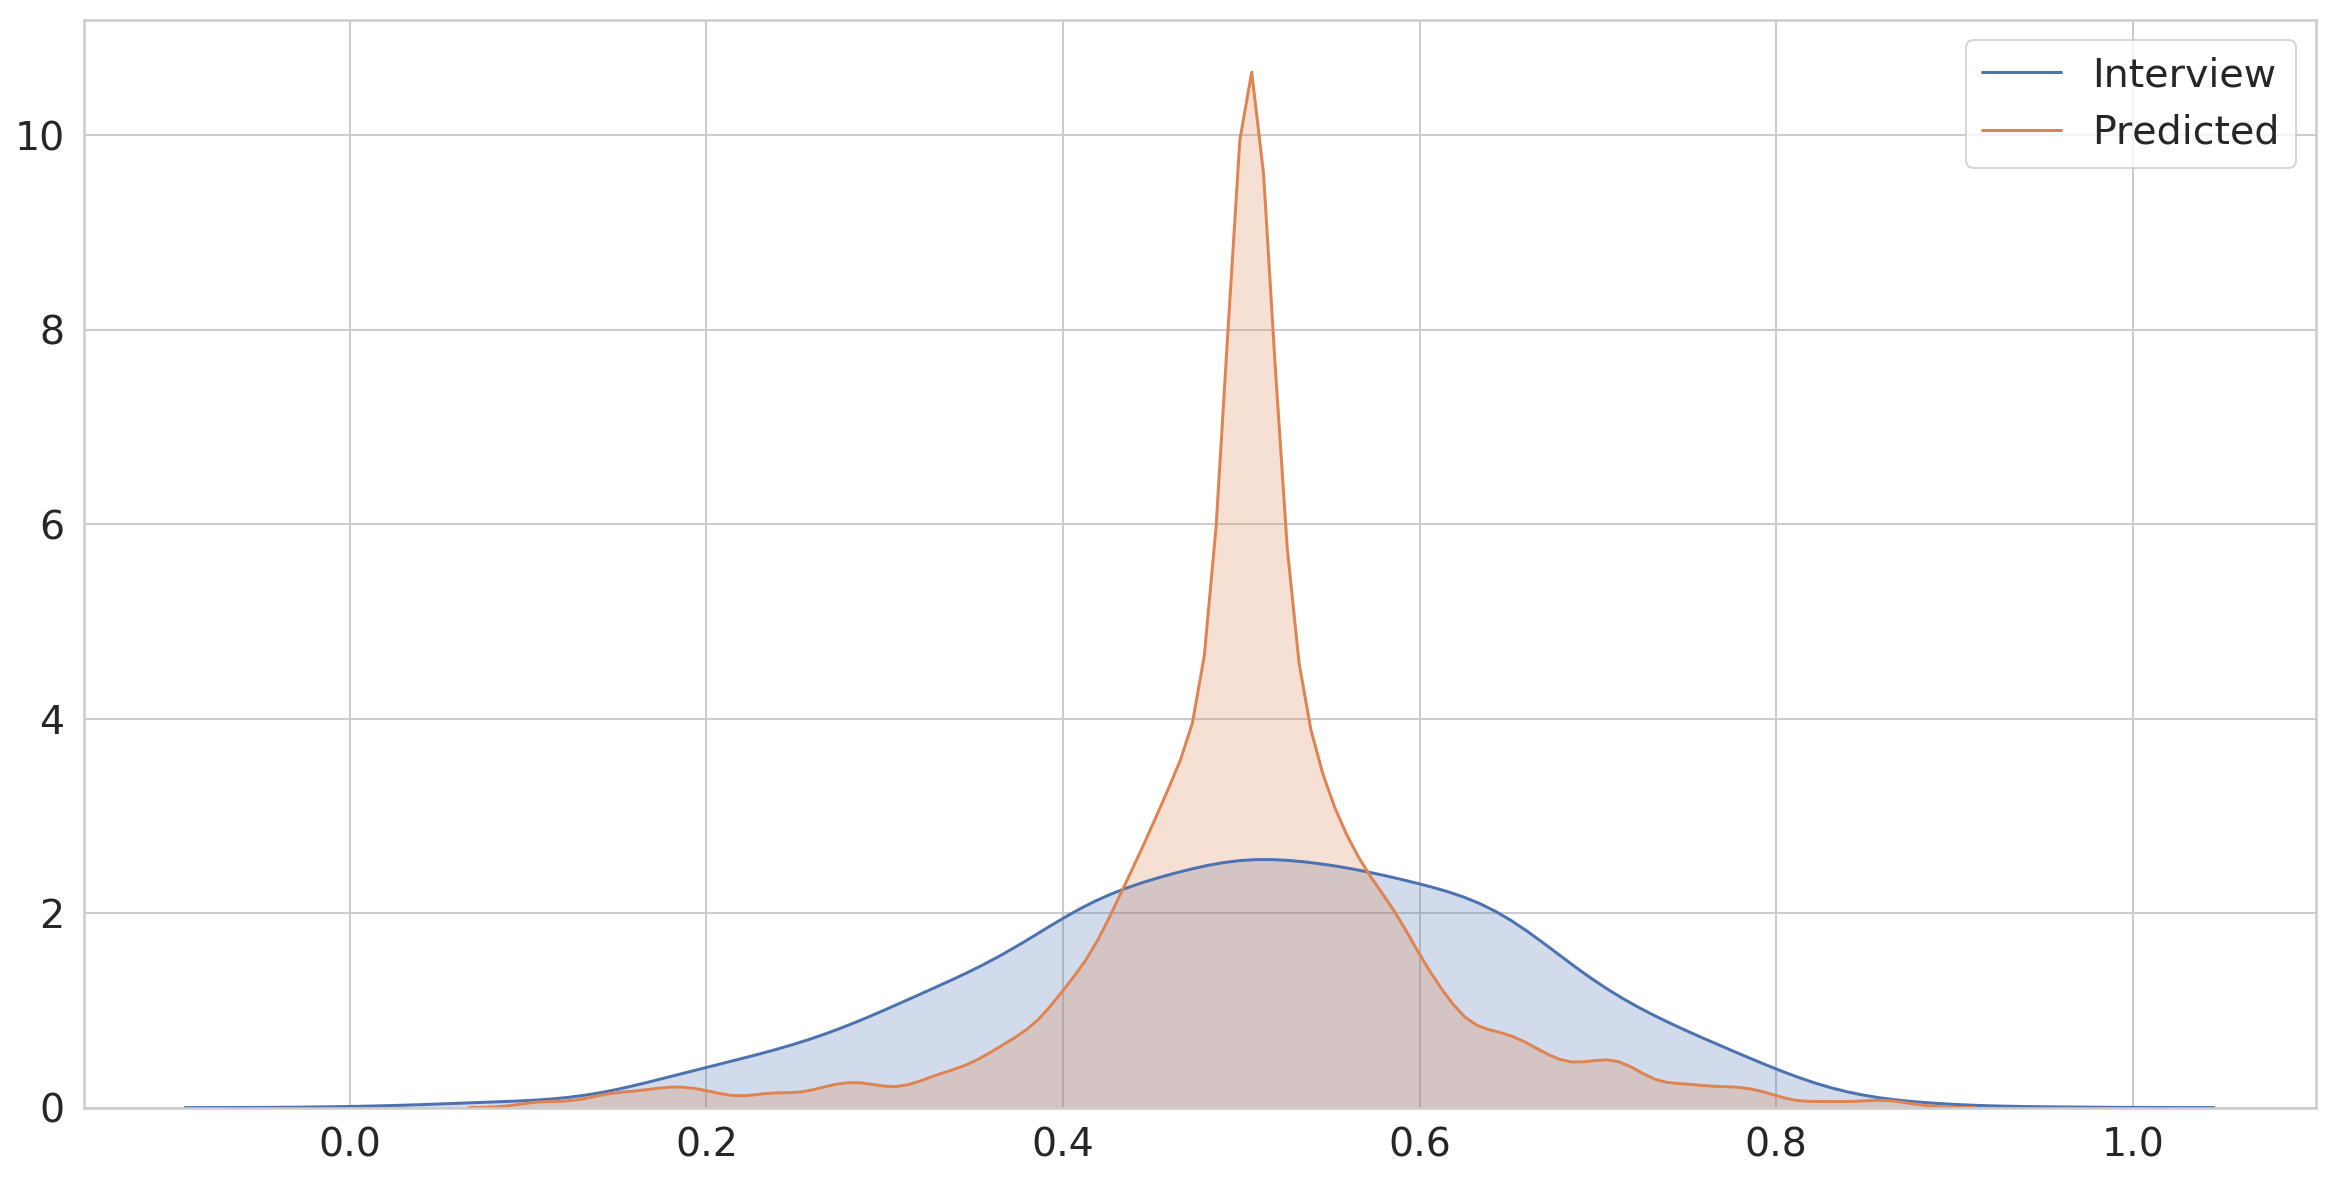

In [22]:
import seaborn as sns

'https://seaborn.pydata.org/tutorial/distributions.html'
'http://people.duke.edu/~ccc14/cfar-data-2016/Customizing_Plots_Solutions.html'

seaborn.set(style="whitegrid", font_scale = 1.8)
fig, ax = plt.subplots()
sns.distplot(Y_test, label='Interview')
sns.distplot([row['prediction'] for row in predictions.collect()], label='Predicted')
        
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)#, rotation=90)
    
plt.legend(['Interview', 'Predicted'],fontsize=20)
plt.show()
fig.savefig('Distribution_Interview_vs_Prediction.eps')

#with plt.style.context('seaborn-white'):
seaborn.set(style="whitegrid", font_scale = 1.8)
fig, ax = plt.subplots()
    
sns.kdeplot(Y_test, label='Interview', shade=True)
sns.kdeplot([row['prediction'] for row in predictions.collect()], label='Predicted', shade=True)

#    plt.xticks(fontsize=18)
#    plt.yticks(fontsize=18)
    
plt.legend(['Interview', 'Predicted'])#,fontsize=20)
plt.show()

Text(0.5, 0, 'Population')

Text(0, 0.5, 'ECDF')

Text(0.5, 1.0, 'Empirical Cumulative Distribution Function of Interview vs Prediction')

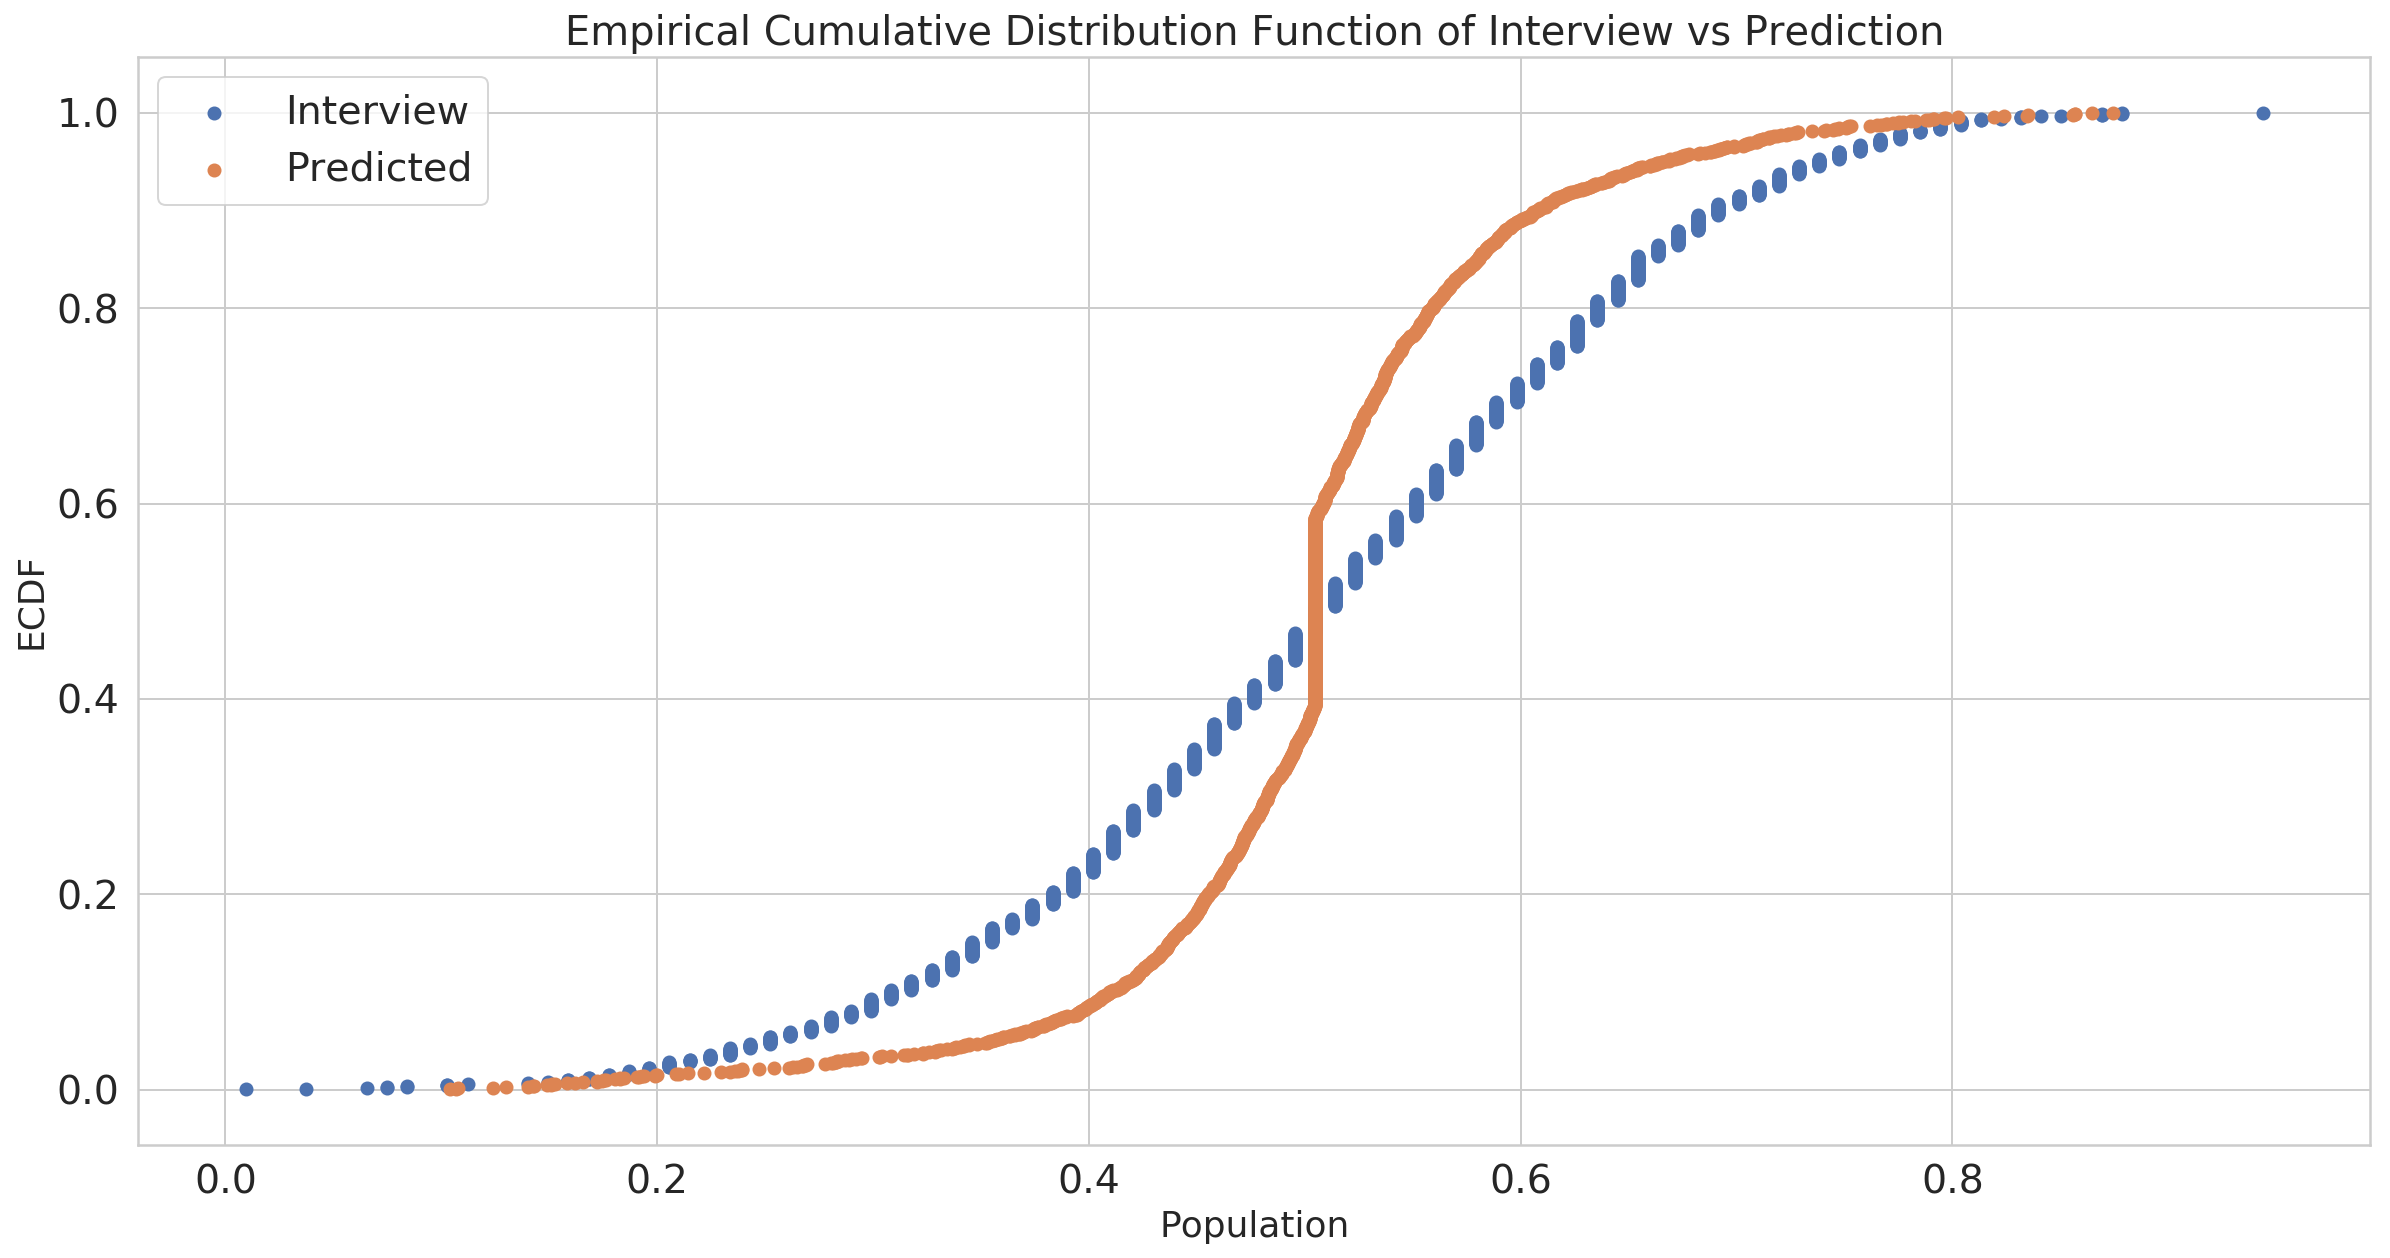

In [42]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf_Y = ECDF(Y_test)
ecdf_P = ECDF([row['prediction'] for row in predictions.collect()])

seaborn.set(style="whitegrid", font_scale = 1.8)
fig, ax = plt.subplots()
    
plt.scatter(ecdf_Y.x, ecdf_Y.y)
plt.scatter(ecdf_P.x, ecdf_P.y)
    
plt.xlabel('Population', fontsize=18)
plt.ylabel('ECDF', fontsize=18)

plt.title('Empirical Cumulative Distribution Function of Interview vs Prediction', fontsize=20)

plt.legend(['Interview', 'Predicted'])
plt.show()
fig.savefig('ECDF_Interview_vs_Prediction.eps')

In [44]:
def max_distance_cumulative(data1, data2):
    """
    Computes the maximal vertical distance between cumulative distributions
    (this is the statistic for KS tests). Code mostly copied from
    scipy.stats.ks_twosamp

    Parameters
    ----------
    data1 : array_like
        First data set
    data2 : array_like
        Second data set
    Returns
    -------
    d : float
        Max distance, i.e. value of the Kolmogorov Smirnov test. Sign is + if
        the cumulative of data1 < the one of data2 at that location, else -.
    x : float
        Value of x where maximal distance d is reached.
    """
    from numpy import ma

    (data1, data2) = (ma.asarray(data1), ma.asarray(data2))
    (n1, n2) = (data1.count(), data2.count())
    mix = ma.concatenate((data1.compressed(), data2.compressed()))
    mixsort = mix.argsort(kind='mergesort')
    csum = np.where(mixsort < n1, 1./n1, -1./n2).cumsum()

    # Check for ties
    if len(np.unique(mix)) < (n1+n2):
        ind = np.r_[np.diff(mix[mixsort]).nonzero()[0], -1]
        csum = csum[ind]
        mixsort = mixsort[ind]

    csumabs = ma.abs(csum)
    i = csumabs.argmax()

    d = csum[i]
    # mixsort[i] contains the index of mix with the max distance
    x = mix[mixsort[i]]

    return (d, x)

(d, x) = max_distance_cumulative(Y_test, [row['prediction'] for row in predictions.collect()])
print((d, x))

(-0.19650000000000017, 0.5607383673347368)


In [48]:
'https://www.graphpad.com/guides/prism/7/statistics/interpreting_results_kolmogorov-smirnov_test.htm'
from scipy.stats.mstats import ks_twosamp

p = np.asarray(Y_test)
q = np.asarray([row['prediction'] for row in predictions.collect()])

test_stat = ks_twosamp(p, q)

print(test_stat)

data1 = np.sort(p)
data2 = np.sort(q)
n1 = data1.shape[0]
n2 = data2.shape[0]
data_all = np.concatenate([data1, data2])
cdf1 = np.searchsorted(data1, data_all, side='right') / n1
cdf2 = np.searchsorted(data2, data_all, side='right') / n2
d = np.max(np.absolute(cdf1 - cdf2))

print(d)

(0.19650000000000017, 5.792363096071429e-34)
0.1965


In [28]:
import numpy as np
import scipy.stats


def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

distance = jensen_shannon_distance([row['prediction'] for row in predictions.collect()], Y_test)
print(round(1-distance,2))

0.87


# This section is dedicated for Streaming

In [ ]:
def get_prediction(test):
    try:
        test = test.map(lambda x : PreprocessTranscript(x))               
        # create a dataframe with column name 'Speech' and each row will contain the Speech
        rowRdd = test.map(lambda w: Row(Speech=w))
        # create a spark dataframe
        df_test = spark.createDataFrame(rowRdd)
        # transform the data using the pipeline and get the predicted Interview
        model.transform(df_test).select('Speech','prediction').show()
    except : 
        print('No data')


In [ ]:
# initialize the streaming context 
ssc = StreamingContext(sc, batchDuration= 3)

# Create a DStream that will connect to hostname:port, like localhost:9991
lines = ssc.socketTextStream(sys.argv[1], int(sys.argv[2]))

# get the predicted sentiments for the tweets received
test.foreachRDD(get_prediction)

# Start the computation
ssc.start()             

# Wait for the computation to terminate
ssc.awaitTermination()